In [3]:
library('rjags')

Loading required package: coda
Linked to JAGS 4.3.0
Loaded modules: basemod,bugs


In [4]:
update_mu = function(n, ybar, sig2, mu_0, sig2_0) {
  sig2_1 = 1.0 / (n / sig2 + 1.0 / sig2_0)
  mu_1 = sig2_1 * (n * ybar / sig2 + mu_0 / sig2_0)
  rnorm(n=1, mean=mu_1, sd=sqrt(sig2_1))
}

In [5]:
update_sig2 = function(n, y, mu, nu_0, beta_0) {
  nu_1 = nu_0 + n / 2.0
  sumsq = sum( (y - mu)^2 ) # vectorized
  beta_1 = beta_0 + sumsq / 2.0
  out_gamma = rgamma(n=1, shape=nu_1, rate=beta_1) # rate for gamma is shape for inv-gamma
  1.0 / out_gamma # reciprocal of a gamma random variable is distributed inv-gamma
}

In [6]:
gibbs = function(y, n_iter, init, prior) {
  ybar = mean(y)
  n = length(y)
  
  ## initialize
  mu_out = numeric(n_iter)
  sig2_out = numeric(n_iter)
  
  mu_now = init$mu
  
  ## Gibbs sampler
  for (i in 1:n_iter) {
    sig2_now = update_sig2(n=n, y=y, mu=mu_now, nu_0=prior$nu_0, beta_0=prior$beta_0)
    mu_now = update_mu(n=n, ybar=ybar, sig2=sig2_now, mu_0=prior$mu_0, sig2_0=prior$sig2_0)
    
    sig2_out[i] = sig2_now
    mu_out[i] = mu_now
  }
  
  cbind(mu=mu_out, sig2=sig2_out)
}

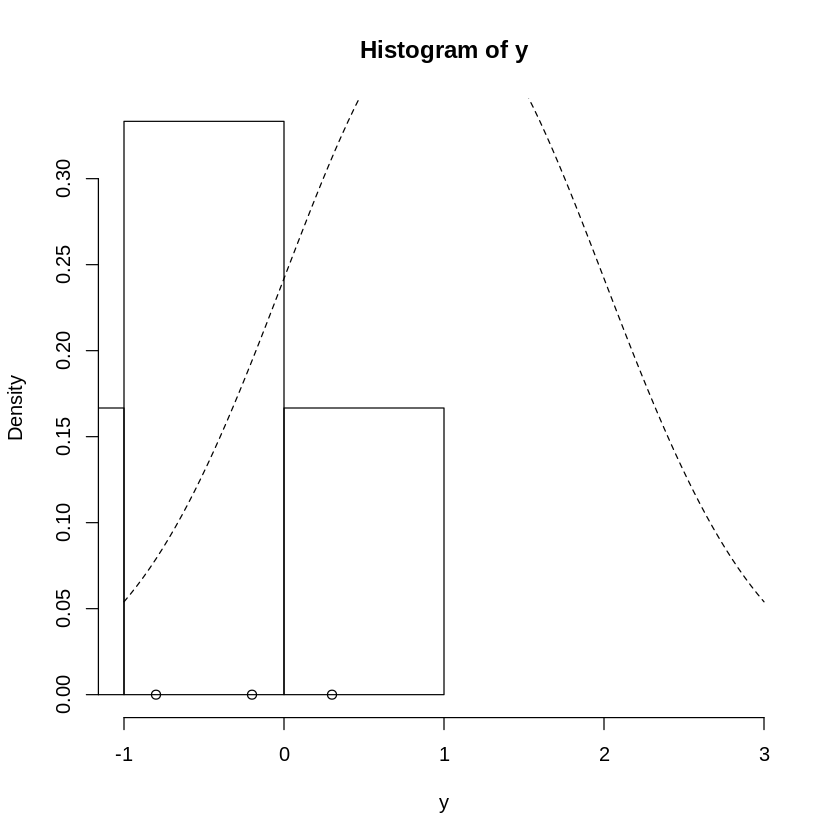

In [12]:
y = c(-0.2, -1.5, -5.3, 0.3, -0.8, -2.2)
ybar = mean(y)
n = length(y)

## prior
prior = list()
prior$mu_0 = 1.0
prior$sig2_0 = 1.0
prior$n_0 = 2.0 # prior effective sample size for sig2
prior$s2_0 = 1.0 # prior point estimate for sig2
prior$nu_0 = prior$n_0 / 2.0 # prior parameter for inverse-gamma
prior$beta_0 = prior$n_0 * prior$s2_0 / 2.0 # prior parameter for inverse-gamma

hist(y, freq=FALSE, xlim=c(-1.0, 3.0)) # histogram of the data
curve(dnorm(x=x, mean=prior$mu_0, sd=sqrt(prior$sig2_0)), lty=2, add=TRUE) # prior for mu
points(y, rep(0,n), pch=1) # individual data points
points(ybar, 0, pch=19) # sample mean

In [13]:
set.seed(53)

init = list()
init$mu = 0.0

post = gibbs(y=y, n_iter=5e3, init=init, prior=prior)

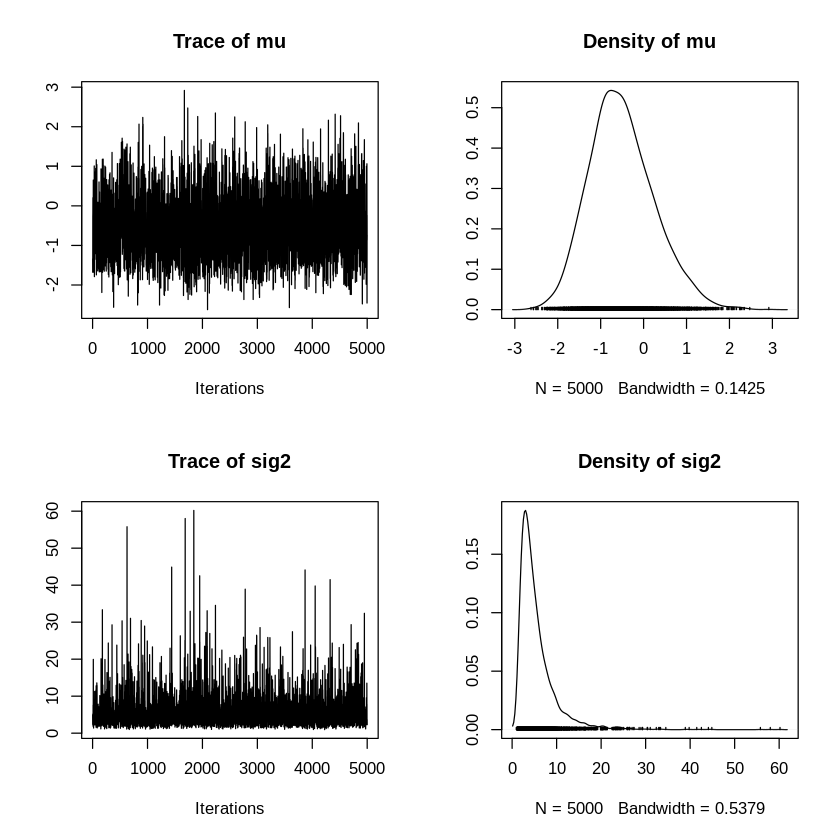

In [14]:
library("coda")
plot(as.mcmc(post))

In [15]:
summary(as.mcmc(post))


Iterations = 1:5000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 5000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

        Mean     SD Naive SE Time-series SE
mu   -0.5071 0.7549  0.01068        0.01334
sig2  5.4989 4.3818  0.06197        0.07592

2. Quantiles for each variable:

       2.5%    25%     50%      75%  97.5%
mu   -1.828 -1.028 -0.5676 -0.03787  1.118
sig2  1.536  2.870  4.2764  6.60483 17.002
